In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f30d9455f663ee578a76b878575c4624b8d32d5d09618da243e41e5fd2107d12
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=9eff4de1773a5928bfb72c7e768ff112508bddd0f43d84dc9ad06b665a374886
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 9.74 MiB/s, done.
Updating files: 100% (12939/12939), done.


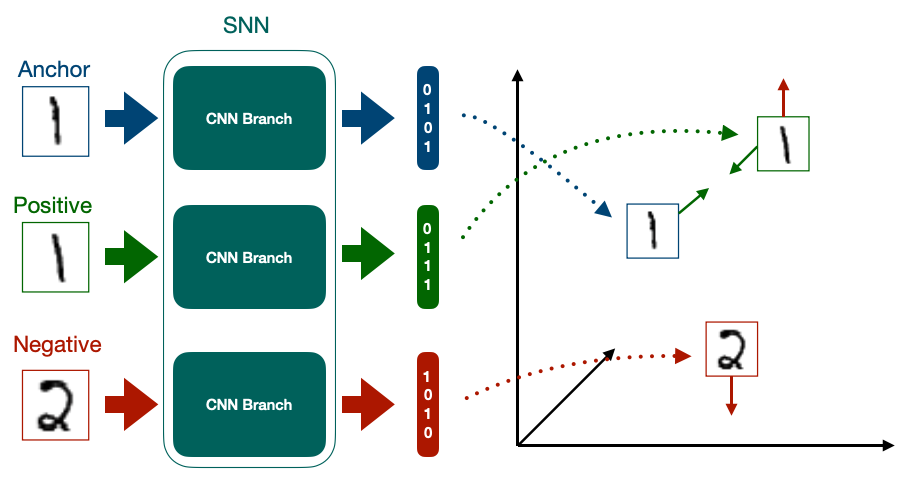

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = .001
EPOCHS = 15

DEVICE = 'cuda'


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

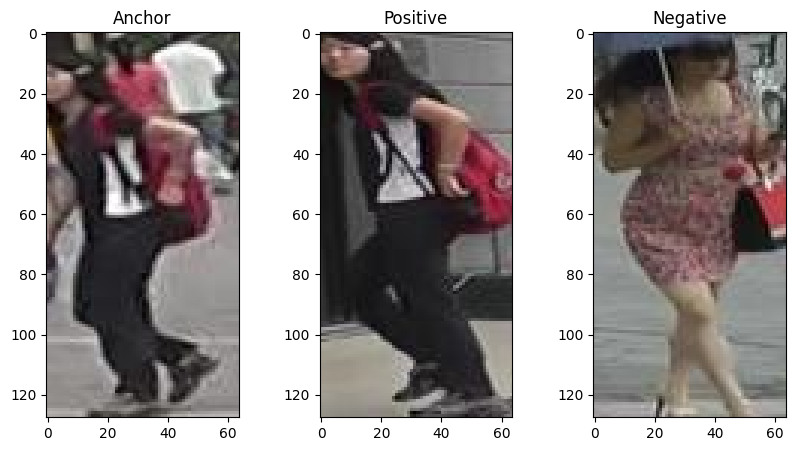

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)


In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)


# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img


In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")


Size of trainset : 3200
Size of validset : 800


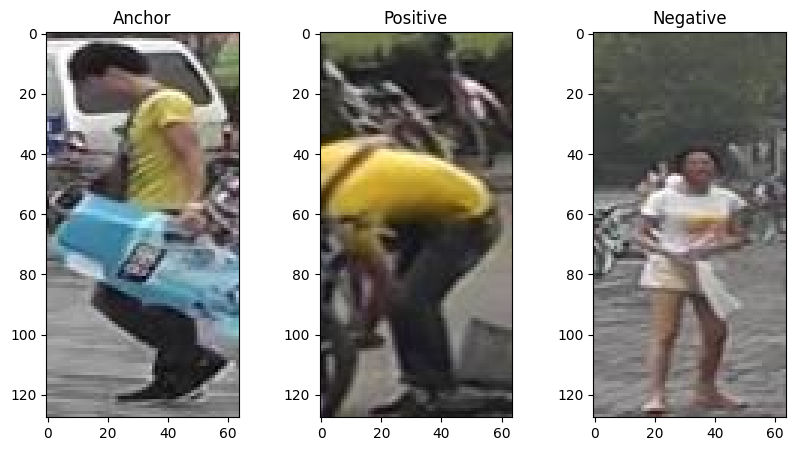

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
    break

print(f"One image batch shape : {A.shape}")


One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(
            in_features=self.efficientnet.classifier.in_features,
            out_features=emb_size
        )

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [ ]:
model = APN_Model()
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()  # Enable training mode (e.g., Dropout active)
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):
        # Move Anchor, Positive, and Negative images to the specified device
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        # Forward pass for each image in the triplet
        A_embs = model(A)  # Anchor embeddings
        P_embs = model(P)  # Positive embeddings
        N_embs = model(N)  # Negative embeddings

        # Compute the triplet loss
        loss = criterion(A_embs, P_embs, N_embs)

        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

        # Accumulate total loss
        total_loss += loss.item()

    return total_loss


In [ ]:
def eval_fn(model, dataloader, criterion):
    model.eval()  # Enable evaluation mode (e.g., Dropout is OFF)
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for A, P, N in tqdm(dataloader):
            # Move Anchor, Positive, and Negative images to the specified device
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            # Forward pass for each image in the triplet
            A_embs = model(A)  # Anchor embeddings
            P_embs = model(P)  # Positive embeddings
            N_embs = model(N)  # Negative embeddings

            # Compute the triplet loss
            loss = criterion(A_embs, P_embs, N_embs)

            # Accumulate total loss
            total_loss += loss.item()

    # Return the average loss over all batches
    return total_loss / len(dataloader)


In [ ]:
criterion = nn.TripletMarginLoss()  # Define the triplet margin loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # Define the optimizer


# Create Training Loop

In [ ]:
best_valid_loss = np.Inf  # Initialize the best validation loss to infinity

for i in range(EPOCHS):  # Loop over the number of epochs
    # Train and evaluate the model
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    # Check if the validation loss improves
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')  # Save the model weights
        best_valid_loss = valid_loss  # Update the best validation loss
        print("SAVED_WEIGHTS_SUCCESS")

    # Print the training and validation loss for the current epoch
    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 63.080999776721 valid_loss : 0.37791969895362854


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 26.07319165766239 valid_loss : 0.3101171153783798


100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 16.039014980196953 valid_loss : 0.20948465287685394


100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 11.6970284730196 valid_loss : 0.1853003227710724


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss : 6.735458493232727 valid_loss : 0.133481006026268


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 6 train_loss : 4.528641015291214 valid_loss : 0.11026171326637269


100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


EPOCHS : 7 train_loss : 8.021862953901291 valid_loss : 0.18932974457740784


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


EPOCHS : 8 train_loss : 8.777701541781425 valid_loss : 0.1268664640188217


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


EPOCHS : 9 train_loss : 7.270469650626183 valid_loss : 0.1404646646976471


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


EPOCHS : 10 train_loss : 4.00811130553484 valid_loss : 0.14044848591089248


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 11 train_loss : 2.6853728592395782 valid_loss : 0.09322482764720917


100%|██████████| 25/25 [00:04<00:00,  6.06it/s]


EPOCHS : 12 train_loss : 3.2204247564077377 valid_loss : 0.14861899018287658


100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


EPOCHS : 13 train_loss : 4.222834184765816 valid_loss : 0.12436615347862244


100%|██████████| 25/25 [00:04<00:00,  5.81it/s]


EPOCHS : 14 train_loss : 3.241748809814453 valid_loss : 0.21772016167640687


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]

EPOCHS : 15 train_loss : 5.305805757641792 valid_loss : 0.18194278538227082


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([pd.DataFrame(anc_img_names_arr, columns=["ImageName"]), encodings], axis=1)

    return df_enc


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])


<ipython-input-35-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:46<00:00, 

In [ ]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()


,ImageName,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.193612,0.518867,0.178345,-0.296340,0.683265,0.875687,-0.943347,0.712097,0.046921,...,0.898379,0.681050,-0.267064,-0.857035,0.309908,-0.194456,0.228252,-0.240976,0.687799,0.154864
1,1420_c3s3_061978_03.jpg,-0.004257,0.631367,0.068174,-0.388410,0.549365,0.769472,-0.652062,0.685483,0.399464,...,0.714130,0.744910,-0.491867,-0.521582,0.121924,-0.479092,-0.088753,-0.006633,0.622933,0.100141
2,1420_c5s3_062565_05.jpg,-0.288195,0.308238,-0.006671,-0.328644,0.461931,0.820432,-0.585190,0.449443,-0.087849,...,1.059407,0.399310,-0.382245,-0.692435,0.369127,-0.047921,-0.074269,0.248683,0.556975,0.119594
3,1420_c6s3_085592_04.jpg,-0.509923,0.383591,0.402837,-0.544163,0.618954,0.534276,-0.466330,0.792205,0.399839,...,0.878266,0.914752,0.333773,-0.864091,0.025723,0.031888,0.902824,-0.448184,0.549607,-0.176631
4,0663_c5s3_085987_03.jpg,-0.676223,-1.021753,0.299933,-0.233304,0.170167,-1.449951,1.434821,-1.214294,-0.446480,...,0.054216,0.222639,1.446357,0.488914,-0.261170,0.262467,1.145129,0.243252,-0.739512,-1.532203


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist


In [ ]:
idx = 0
img_name = df_enc['ImageName'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()


In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['ImageName']


In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
    distance = np.append(distance, dist)


In [ ]:
closest_idx = np.argsort(distance)


/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


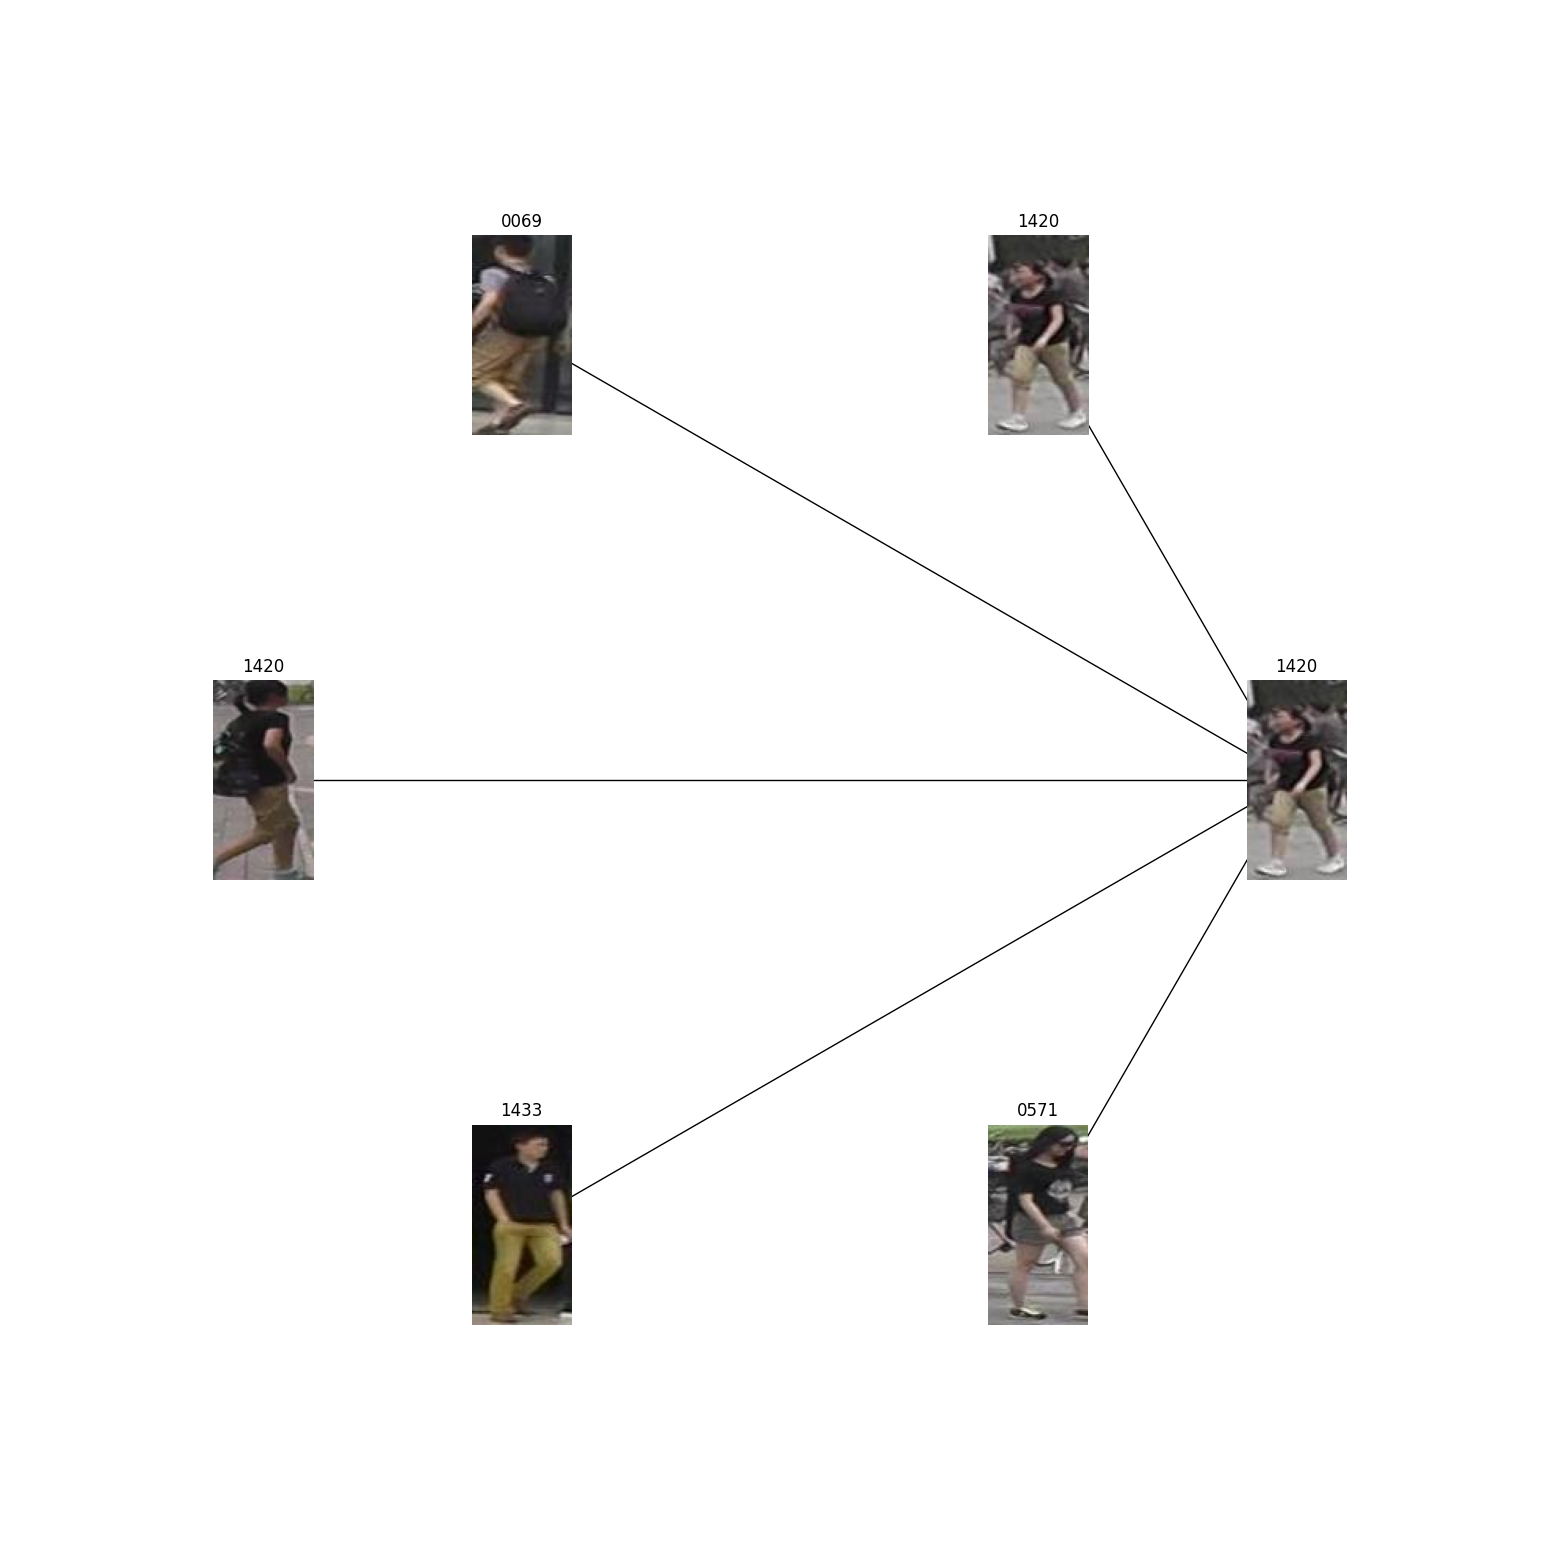

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);